In [1]:
import pandas as pd
import numpy as np
import random
from evaluation import get_acc,get_F1
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

In [2]:
def sigmoid(x):
    if x>=0:
        return 1.0/(1+np.exp(-x))
    else:
        return np.exp(x)/(1+np.exp(x))

#逻辑回归
class LogisticRegression:
    '''参数描述
    lr: 梯度更新的学习率
    Lambda: 收敛条件
    epochs: 更新迭代的次数
    w: 训练参数
    status_dict: 标签列表
    maxmin: 归一化数据
    '''

    def __init__(self, Lambda=0.01, epochs=1000,lr=0.05):
        self.Lambda = Lambda
        self.epochs = epochs
        self.lr = lr
        self.w = []
        self.status_dict=['B','M']
        self.maxmin=[]
        
    def pretreatment(self, df, flag='train'):
        df_c = df.copy()
        #添加一列
        df_c['f31']=1
        if flag=='train':
            #转换标签
            df_c['Label_tran']=df_c['Label'].apply(lambda x : self.status_dict.index(x))
        #特征归一化
        for i in range(30):
            if flag == 'train':
                self.maxmin += [[df_c.iloc[:,i+2].min(axis=0),df_c.iloc[:,i+2].max(axis=0)]]
            df_c.iloc[:,i+2]=(df_c.iloc[:,i+2]-self.maxmin[i][0])/(self.maxmin[i][1]-self.maxmin[i][0])
        return df_c

    def fit(self, train_features, train_labels):
        
        def gold_div_search(a,b,esp,N,w,x,y,dleta):
            rou = 1-(np.sqrt(5)-1)/2 # 1-rou为黄金分割比
            lr1=a+rou*(b-a)
            lr2=b-rou*(b-a)

            while(b-a>esp):

                w1 = w - lr1 * dleta
                w2 = w - lr2 * dleta
                w1_T_x = np.dot(w1.T[0], x)
                w2_T_x = np.dot(w2.T[0], x)
                f1 = 0
                f2 = 0
                for i in range(N):
                    f1 = f1 + (-y[i] * w1_T_x[i] + np.log(1 + np.exp(w1_T_x[i])))
                    f2 = f2 + (-y[i] * w2_T_x[i] + np.log(1 + np.exp(w2_T_x[i])))
                if f1>f2:  #如果f(x1)>function(x2)，则在区间(x1,b)内搜索
                    a=lr1
                    lr1=lr2
                    lr2=b-rou*(b-a)
                elif f1<f2:  #如果f(x1)<function(x2),则在区间(a,x2)内搜索
                    b=lr2
                    lr2=lr1
                    lr1=a+rou*(b-a)
                else:  #如果f(x1)=function(x2)，则在区间(x1,x2)内搜索
                    a=lr1
                    b=lr2
                    lr1=a+rou*(b-a)
                    lr2=b-rou*(b-a)

            return a

        x = np.array(train_features).T
        y = np.array(train_labels)
        num, N = np.shape(x)
        w = np.ones((num, 1))

        L=np.zeros(self.epochs+1)
        L[0]=1000
        
#         Hk = np.eye(31)
        for j in range(self.epochs):
            w_T_x = np.dot(w.T[0], x)
            
            # 收敛条件
            for i in range(N):
                L[j+1] = L[j+1] + (-y[i] * w_T_x[i] + np.log(1 + np.exp(w_T_x[i])))
            if np.abs(L[j+1] - L[j]) <= self.Lambda:
                print(L[j+1])
                break
                
            # 计算梯度
            dbeta = 0  # 一阶导
            for i in range(N):
                p1 = sigmoid(w_T_x[i])
                dbeta = dbeta - np.array([x[:, i]]).T * (y[i] - p1)
            gk = dbeta
#             dk = -1.0*np.dot(Hk,gk)

            # 优化参数
            self.lr = gold_div_search(0,1,0.005,N=N,w=w,x=x,y=y,dleta=gk)
            w = w - self.lr * gk

#             self.lr = gold_div_search(0,1,0.005,N=N,w=w,x=x,y=y,dleta=-dk)
            
            
#             w_new = w + self.lr * dk
            
#             sk = w_new - w
#             w_new_T_x = np.dot(w_new.T[0], x)
            
#             dbeta = 0
#             for i in range(N):
#                 p1 = sigmoid(w_new_T_x[i])
#                 dbeta = dbeta - np.array([x[:, i]]).T * (y[i] - p1)
        
#             yk = dbeta - gk
    
#             if np.dot(sk.T,yk) > 0:
#                 Hy = np.dot(np.dot(Hk,yk),yk.T)
#                 sy = np.dot(sk.T,yk)
#                 yHy = np.dot(np.dot(yk.T,Hk),yk)
#                 Hk = Hk - np.dot(Hy,Hk)/yHy + np.dot(sk,sk.T)/sy
                    
#             w = w_new
            epochs = j+1

        self.w = w
        
        # 可视化
        plt.figure(figsize=(10,6),dpi=80)
        x=np.linspace(1,epochs,epochs)
        y=L[1:epochs+1]
        plt.plot(x, y,color='#4876FF')

        plt.xlabel("迭代次数")
        plt.ylabel("负对数似然值")
        plt.title("损失下降曲线")
        plt.show()
        return epochs
        

    def predict(self, test_features):
        
        x=np.array(test_features).T
        w_T_x=np.dot(self.w.T[0],x)
        
        pre=np.zeros((x.shape[1],1))
        y=np.zeros((x.shape[1],1))
        
        for i in range(pre.shape[0]):
            pre[i] = sigmoid(w_T_x[i])
            if pre[i] < 0.5:
                y[i] = 0
            elif pre[i] > 0.5:
                y[i] = 1
            else:
                y[i] = random.randint(0,1)

        y_label=pd.DataFrame(y)
        y_label= y_label.iloc[:,0].apply(lambda x : self.status_dict[int(x)])
        y_label=np.array(y_label)
        return y_label

def plotresult(df):
    plt.figure(figsize=(10,5),dpi=80)
    z1=df[df['Label']=='B'].iloc[:,2:33] @ LR.w
    z2=df[df['Label']=='M'].iloc[:,2:33] @ LR.w
    z3=np.linspace(-40,40,100)
    plt.scatter(z1,1/(1+np.exp(-z1)))
    plt.scatter(z2,1/(1+np.exp(-z2)))
    plt.legend(["B","M"])
    plt.plot(z3,1/(1+np.exp(-z3)),'black')
    plt.plot(z3,[0.5]*100,'black',linestyle='--')
    #plt.show()

27.505900397430473


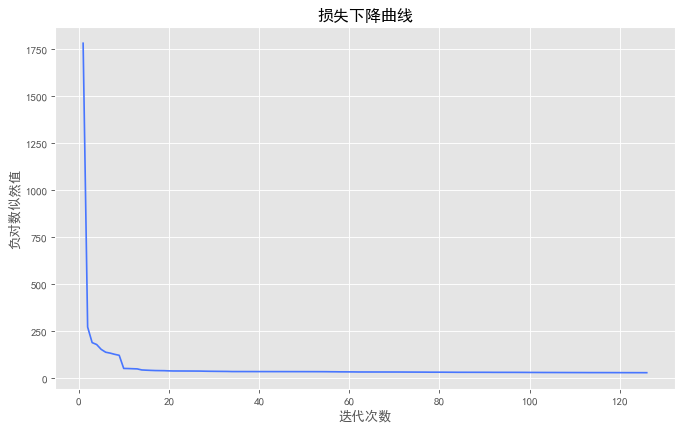

训练 126 次，在训练集上：
准确率： 0.9846153846153847
查准率： 0.9885057471264368 
查全率： 0.9717514124293786 
F1指标： 0.98005698005698


In [3]:
names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc_train.data",names=names)
LR = LogisticRegression(Lambda=0.01,epochs=1000,lr=0.08)
df=LR.pretreatment(df)
epochs = LR.fit(df.iloc[:,2:33],df.iloc[:,33])
y_pre=LR.predict(df.iloc[:,2:33])
acc=get_acc(np.array(df['Label']),y_pre)
print('训练',epochs,'次，在训练集上：\n准确率：',acc)

P,R,F1=get_F1(np.array(df['Label']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

In [4]:
df1 =  pd.read_csv("wdbc_test.data",names=names)
df2 =  pd.read_csv("wdbc.data",names=names)

df3 = df1[['ID','Label']].join(df2[['ID','Label']].set_index('ID'), on='ID',lsuffix='_l', rsuffix='_r')

df1=LR.pretreatment(df1,'test')
y_pre=LR.predict(df1.iloc[:,2:33])
acc=get_acc(np.array(df3['Label_r']),y_pre)
print('在测试集上:\n准确率：',acc)
P,R,F1=get_F1(np.array(df3['Label_r']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)


在测试集上:
准确率： 1.0
查准率： 1.0 
查全率： 1.0 
F1指标： 1.0


In [5]:
y_pre

array(['M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B',
       'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'M',
       'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M',
       'M', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B',
       'B', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'M', 'B'], dtype=object)

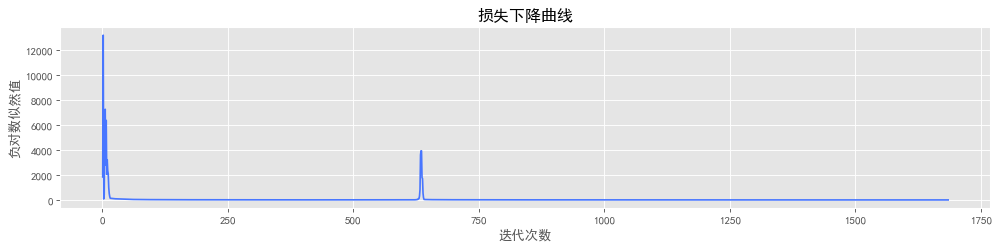

训练 1685 次，在训练集上：
准确率： 0.9868131868131869
查准率： 0.9940476190476191 
查全率： 0.9709302325581395 
F1指标： 0.9823529411764705
在测试集上:
准确率： 1.0
查准率： 1.0 
查全率： 1.0 
F1指标： 1.0


In [21]:
names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc.data",names=names)
df=df.sample(frac=1).reset_index(drop=True)

df=df[0:455]

LR = LogisticRegression()
df=LR.pretreatment(df)
epochs = LR.fit(df.iloc[:,2:33],df.iloc[:,33])
y_pre=LR.predict(df.iloc[:,2:33])
acc=get_acc(np.array(df['Label']),y_pre)
print('训练',epochs,'次，在训练集上：\n准确率：',acc)

P,R,F1=get_F1(np.array(df['Label']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)



df1 =  pd.read_csv("wdbc_test.data",names=names)
df2 =  pd.read_csv("wdbc.data",names=names)

df3 = df1[['ID','Label']].join(df2[['ID','Label']].set_index('ID'), on='ID',lsuffix='_l', rsuffix='_r')

df1=LR.pretreatment(df1,'test')
y_pre=LR.predict(df1.iloc[:,2:33])
acc=get_acc(np.array(df3['Label_r']),y_pre)
print('在测试集上:\n准确率：',acc)
P,R,F1=get_F1(np.array(df3['Label_r']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

In [85]:
#随机划分

In [169]:
names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc.data",names=names)
df=df.sample(frac=1).reset_index(drop=True)

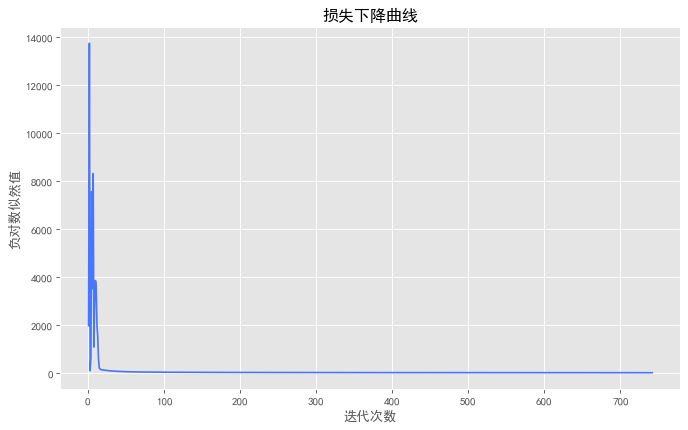

训练 742 次，在训练集上：
准确率： 0.9912087912087912
查准率： 1.0 
查全率： 0.9761904761904762 
F1指标： 0.9879518072289156
在测试集上:
准确率： 0.9824561403508771
查准率： 1.0 
查全率： 0.9545454545454546 
F1指标： 0.9767441860465117


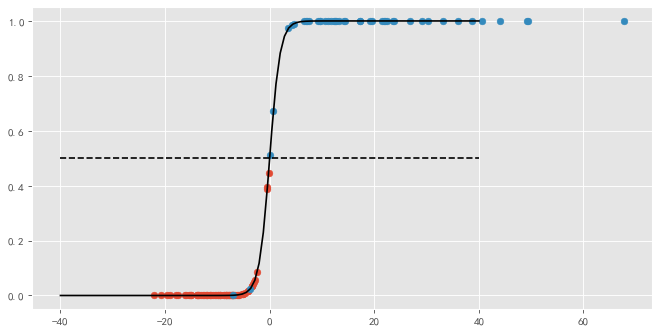

In [192]:
df1=df[0:455]
df2=df[455:]

LR = LogisticRegression(Lambda=0.005)
df1=LR.pretreatment(df1)
epochs = LR.fit(df1.iloc[:,2:33],df1.iloc[:,33])
y_pre=LR.predict(df1.iloc[:,2:33])
acc=get_acc(np.array(df1['Label']),y_pre)
print('训练',epochs,'次，在训练集上：\n准确率：',acc)

P,R,F1=get_F1(np.array(df1['Label']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

df2=LR.pretreatment(df2,'test')
y_pre=LR.predict(df2.iloc[:,2:33])
acc=get_acc(np.array(df2['Label']),y_pre)
print('在测试集上:\n准确率：',acc)
P,R,F1=get_F1(np.array(df2['Label']),y_pre,'M')
print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

plotresult(df2)

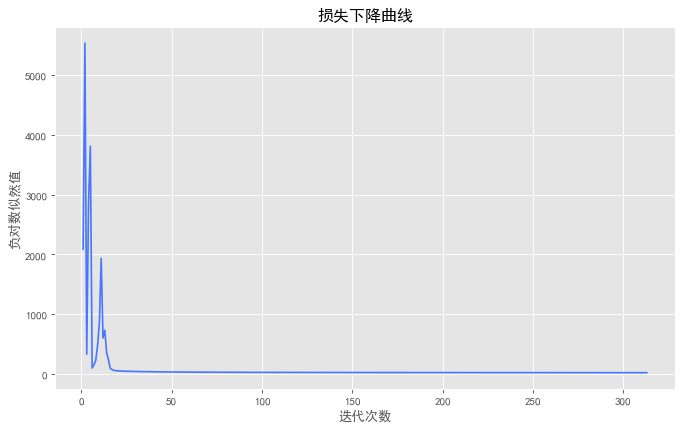

第 1 折：
训练 313 次，在训练集上：
准确率： 0.989010989010989
查准率： 1.0 
查全率： 0.9652777777777778 
F1指标： 0.9823321554770319
在测试集上:
准确率： 0.9736842105263158
查准率： 1.0 
查全率： 0.9558823529411765 
F1指标： 0.9774436090225563


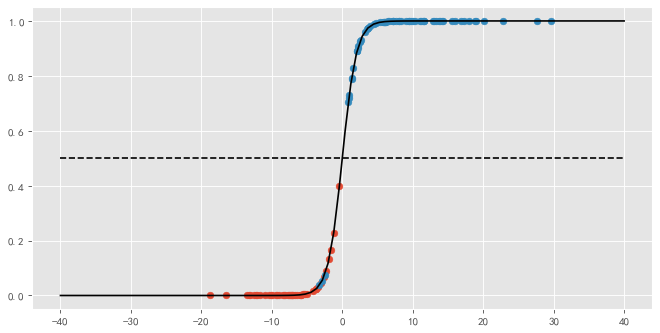

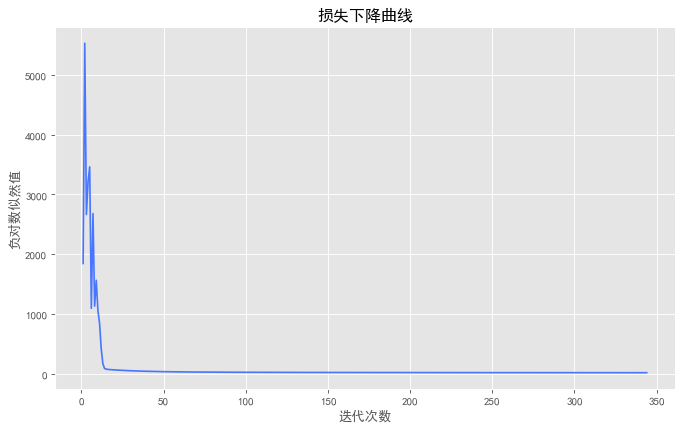

第 2 折：
训练 344 次，在训练集上：
准确率： 0.989010989010989
查准率： 0.99375 
查全率： 0.9754601226993865 
F1指标： 0.9845201238390093
在测试集上:
准确率： 0.956140350877193
查准率： 1.0 
查全率： 0.8979591836734694 
F1指标： 0.9462365591397849


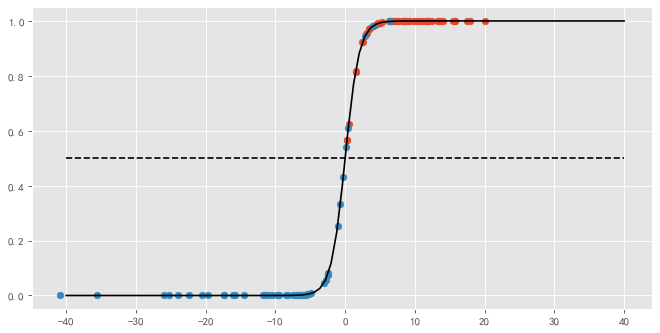

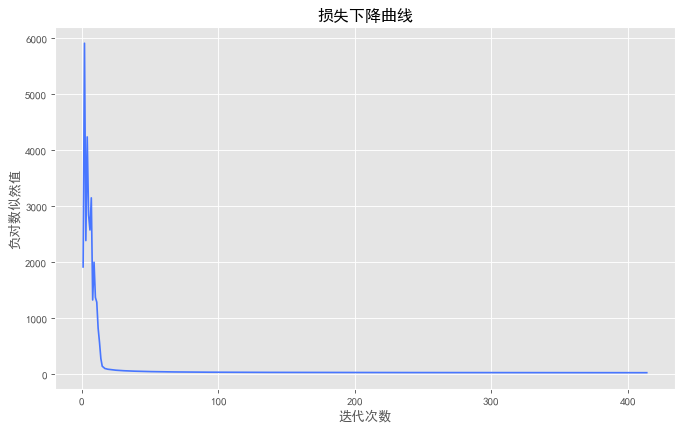

第 3 折：
训练 414 次，在训练集上：
准确率： 0.9868131868131869
查准率： 0.9882352941176471 
查全率： 0.9767441860465116 
F1指标： 0.9824561403508771
在测试集上:
准确率： 0.9649122807017544
查准率： 0.95 
查全率： 0.95 
F1指标： 0.9500000000000001


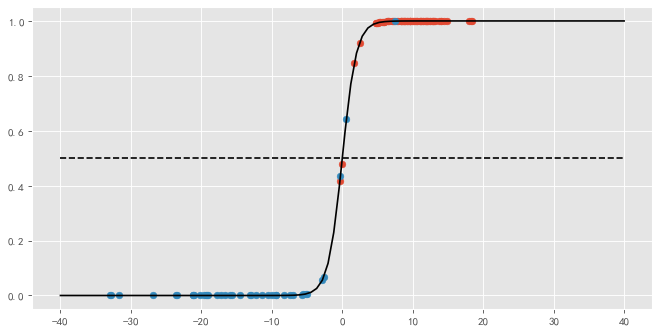

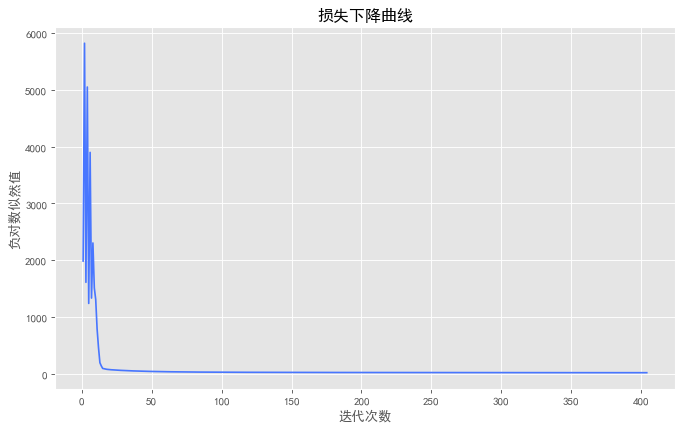

第 4 折：
训练 404 次，在训练集上：
准确率： 0.9824175824175824
查准率： 0.9834254143646409 
查全率： 0.9726775956284153 
F1指标： 0.978021978021978
在测试集上:
准确率： 0.9736842105263158
查准率： 0.90625 
查全率： 1.0 
F1指标： 0.9508196721311475


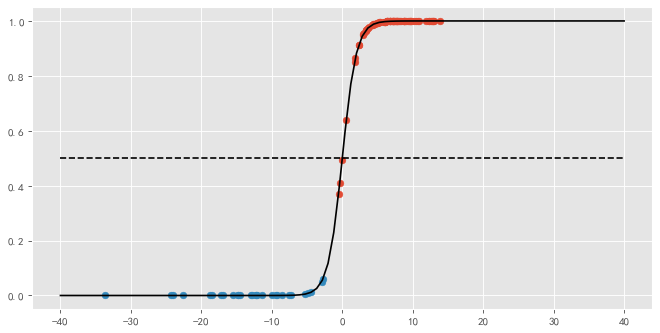

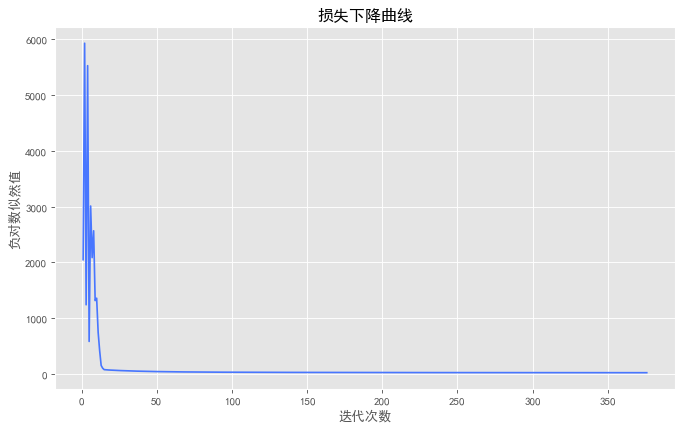

第 5 折：
训练 376 次，在训练集上：
准确率： 0.9780701754385965
查准率： 0.9731182795698925 
查全率： 0.9731182795698925 
F1指标： 0.9731182795698925
在测试集上:
准确率： 0.9911504424778761
查准率： 0.9629629629629629 
查全率： 1.0 
F1指标： 0.9811320754716981

平均准确率： 0.9719142990218911


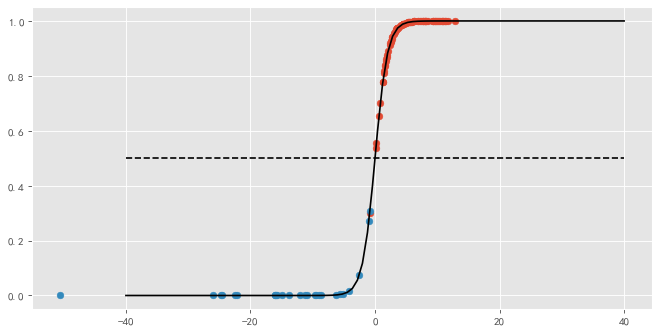

In [193]:
# k折
df1=df[0:455]
df2=df[455:]

names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc.data",names=names)

avg_acc=0
for i in range(5):
    df2=df[i*114:i*114+114]
    df1=pd.concat([df[0:i*114],df[i*114+114:569]])

    LR = LogisticRegression(Lambda=0.01,lr=0.05)
    df1=LR.pretreatment(df1)
    epochs = LR.fit(df1.iloc[:,2:33],df1.iloc[:,33])
    y_pre=LR.predict(df1.iloc[:,2:33])
    acc=get_acc(np.array(df1['Label']),y_pre)
    print('第',i+1,'折：')
    print('训练',epochs,'次，在训练集上：\n准确率：',acc)

    P,R,F1=get_F1(np.array(df1['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

    df2=LR.pretreatment(df2,'test')
    y_pre=LR.predict(df2.iloc[:,2:33])
    acc=get_acc(np.array(df2['Label']),y_pre)
    print('在测试集上:\n准确率：',acc)
    avg_acc += acc
    P,R,F1=get_F1(np.array(df2['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)
    plotresult(df2)
    
print('\n平均准确率：',avg_acc/5)   

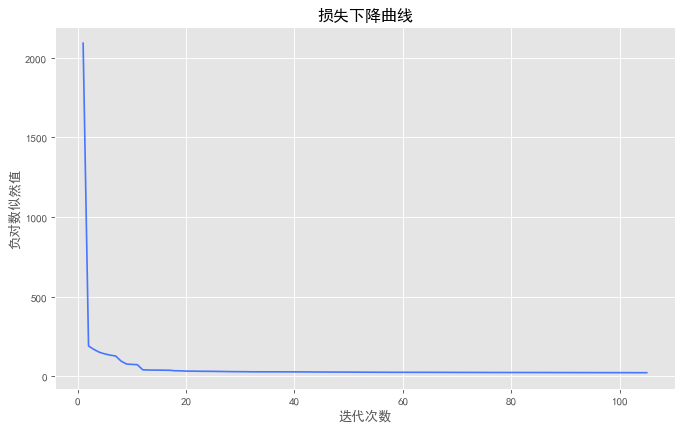

第 1 折：
训练 105 次，在训练集上：
准确率： 0.989010989010989
查准率： 1.0 
查全率： 0.9652777777777778 
F1指标： 0.9823321554770319
在测试集上:
准确率： 0.9649122807017544
查准率： 0.9848484848484849 
查全率： 0.9558823529411765 
F1指标： 0.9701492537313432


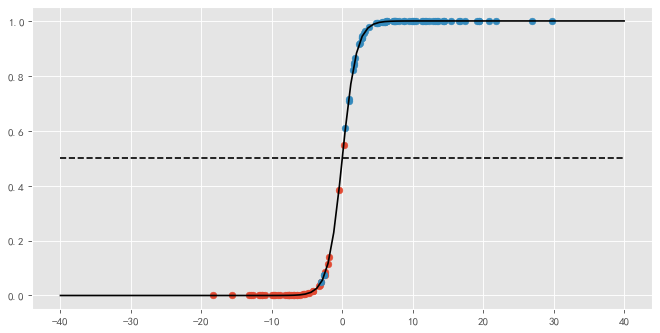

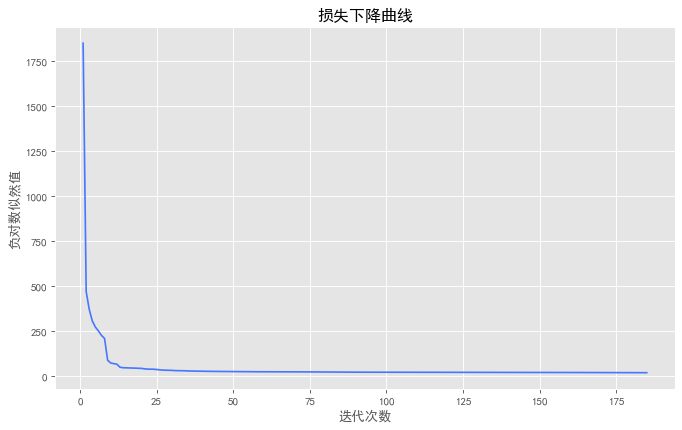

第 2 折：
训练 185 次，在训练集上：
准确率： 0.9912087912087912
查准率： 1.0 
查全率： 0.9754601226993865 
F1指标： 0.9875776397515528
在测试集上:
准确率： 0.956140350877193
查准率： 0.9782608695652174 
查全率： 0.9183673469387755 
F1指标： 0.9473684210526316


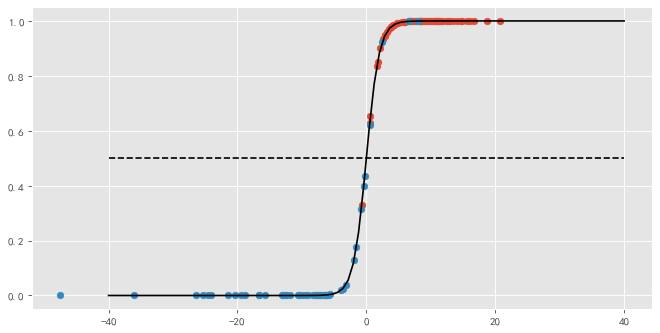

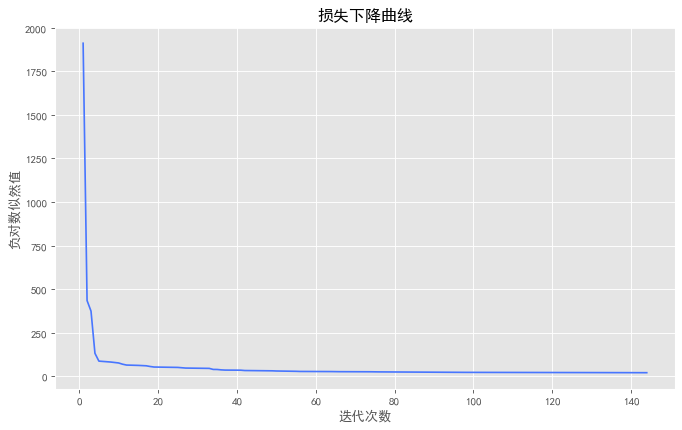

第 3 折：
训练 144 次，在训练集上：
准确率： 0.9868131868131869
查准率： 0.9882352941176471 
查全率： 0.9767441860465116 
F1指标： 0.9824561403508771
在测试集上:
准确率： 0.9824561403508771
查准率： 1.0 
查全率： 0.95 
F1指标： 0.9743589743589743


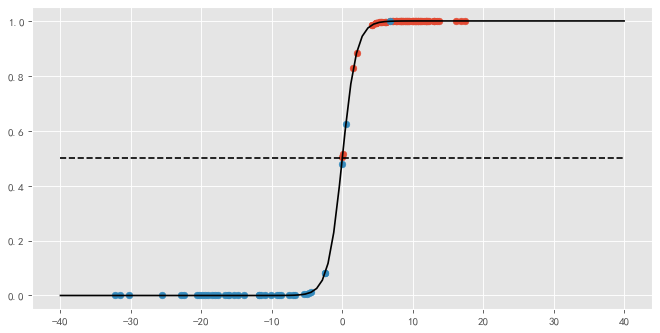

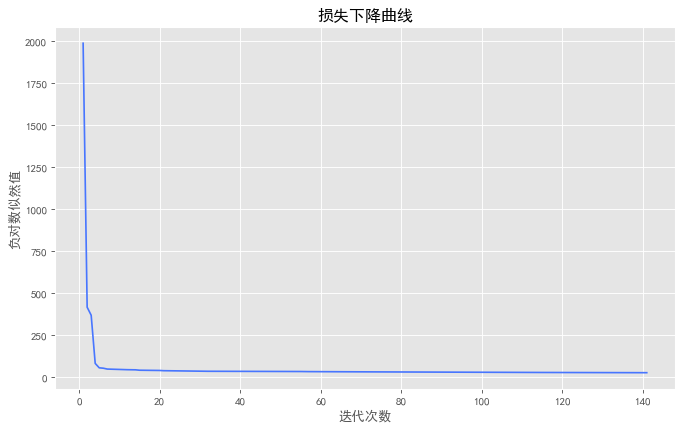

第 4 折：
训练 141 次，在训练集上：
准确率： 0.9868131868131869
查准率： 0.988950276243094 
查全率： 0.9781420765027322 
F1指标： 0.9835164835164836
在测试集上:
准确率： 0.9824561403508771
查准率： 0.9354838709677419 
查全率： 1.0 
F1指标： 0.9666666666666666


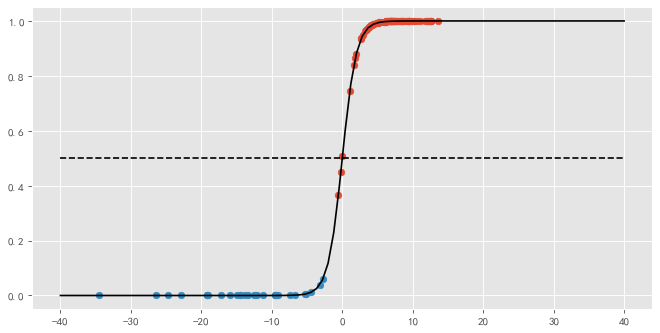

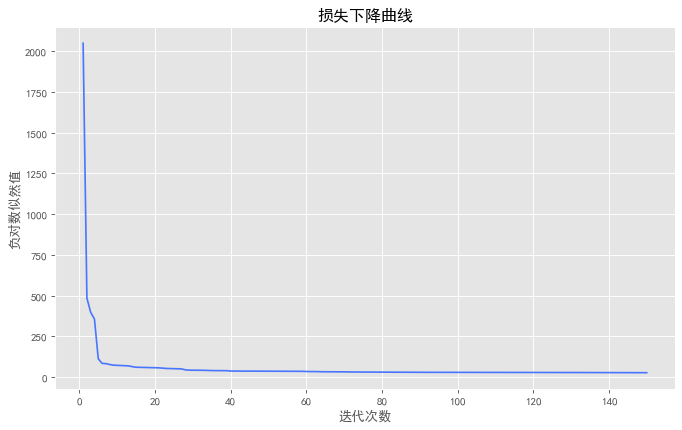

第 5 折：
训练 150 次，在训练集上：
准确率： 0.9802631578947368
查准率： 0.9783783783783784 
查全率： 0.9731182795698925 
F1指标： 0.9757412398921833
在测试集上:
准确率： 0.9911504424778761
查准率： 0.9629629629629629 
查全率： 1.0 
F1指标： 0.9811320754716981

平均准确率： 0.9754230709517155


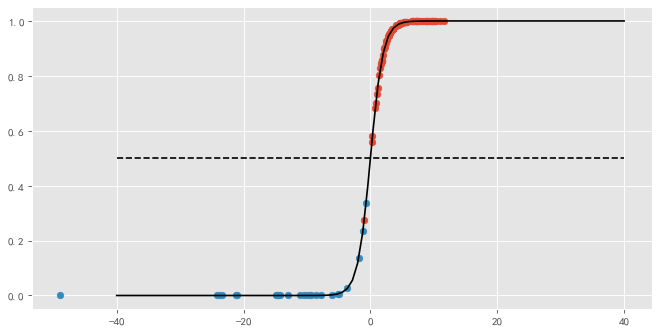

In [45]:
# k折
df1=df[0:455]
df2=df[455:]

names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc.data",names=names)

avg_acc=0
for i in range(5):
    df2=df[i*114:i*114+114]
    df1=pd.concat([df[0:i*114],df[i*114+114:569]])

    LR = LogisticRegression(Lambda=0.01,lr=0.05)
    df1=LR.pretreatment(df1)
    epochs = LR.fit(df1.iloc[:,2:33],df1.iloc[:,33])
    y_pre=LR.predict(df1.iloc[:,2:33])
    acc=get_acc(np.array(df1['Label']),y_pre)
    print('第',i+1,'折：')
    print('训练',epochs,'次，在训练集上：\n准确率：',acc)

    P,R,F1=get_F1(np.array(df1['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

    df2=LR.pretreatment(df2,'test')
    y_pre=LR.predict(df2.iloc[:,2:33])
    acc=get_acc(np.array(df2['Label']),y_pre)
    print('在测试集上:\n准确率：',acc)
    avg_acc += acc
    P,R,F1=get_F1(np.array(df2['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)
    plotresult(df2)
    
print('\n平均准确率：',avg_acc/5)   

21.80733868197738


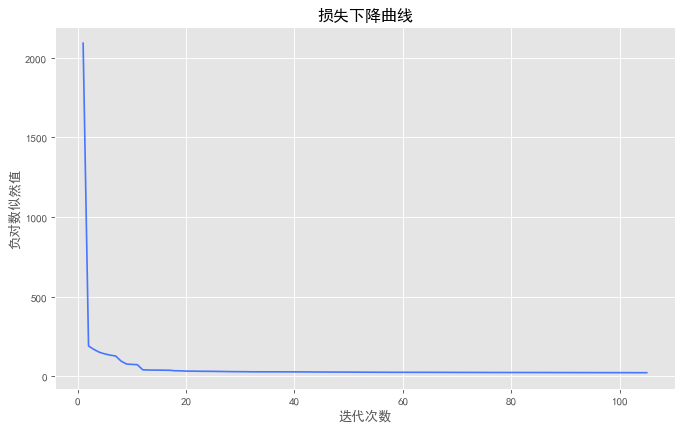

第 1 折：
训练 105 次，在训练集上：
准确率： 0.989010989010989
查准率： 1.0 
查全率： 0.9652777777777778 
F1指标： 0.9823321554770319
在测试集上:
准确率： 0.9649122807017544
查准率： 0.9848484848484849 
查全率： 0.9558823529411765 
F1指标： 0.9701492537313432
20.521202854439988


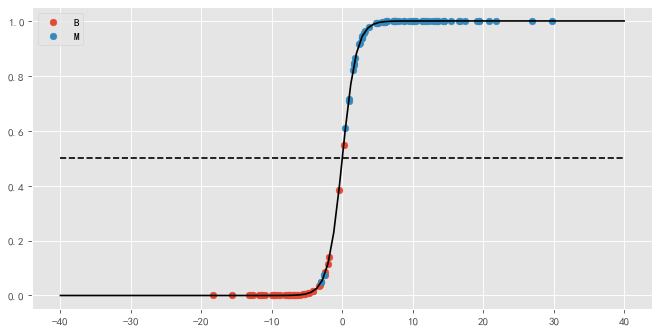

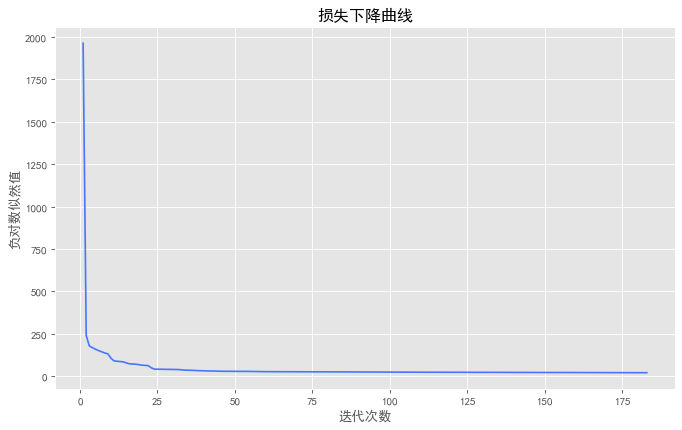

第 2 折：
训练 183 次，在训练集上：
准确率： 0.9912087912087912
查准率： 1.0 
查全率： 0.9754601226993865 
F1指标： 0.9875776397515528
在测试集上:
准确率： 0.956140350877193
查准率： 0.9782608695652174 
查全率： 0.9183673469387755 
F1指标： 0.9473684210526316
18.78648994419232


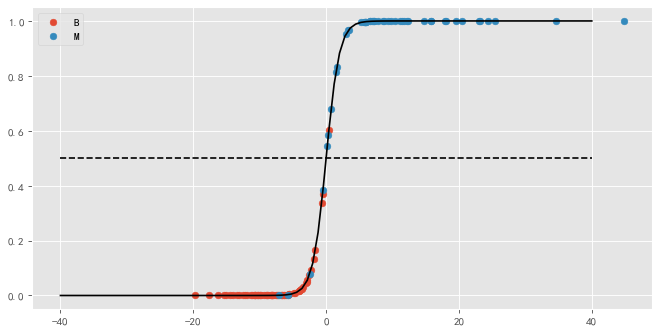

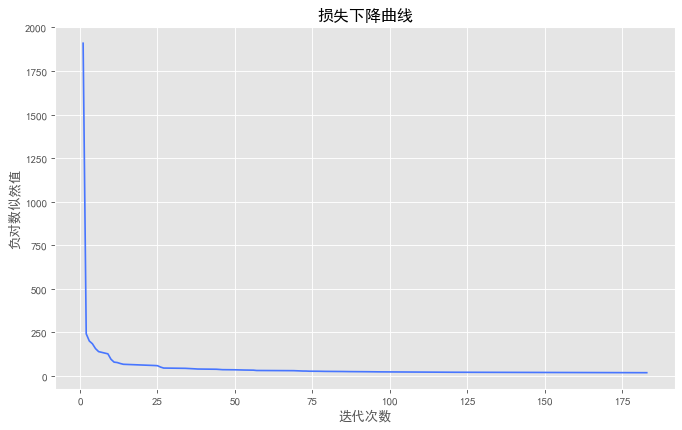

第 3 折：
训练 183 次，在训练集上：
准确率： 0.989010989010989
查准率： 0.9883040935672515 
查全率： 0.9825581395348837 
F1指标： 0.9854227405247813
在测试集上:
准确率： 0.9824561403508771
查准率： 1.0 
查全率： 0.95 
F1指标： 0.9743589743589743
25.87954424634779


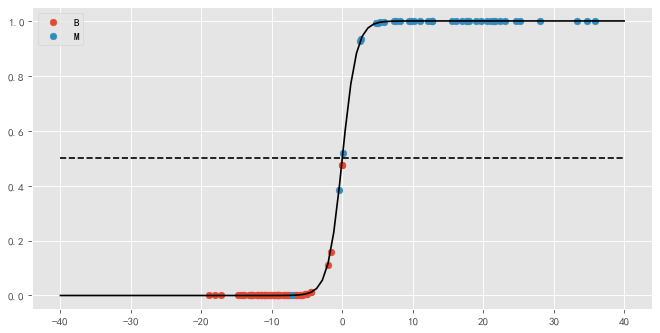

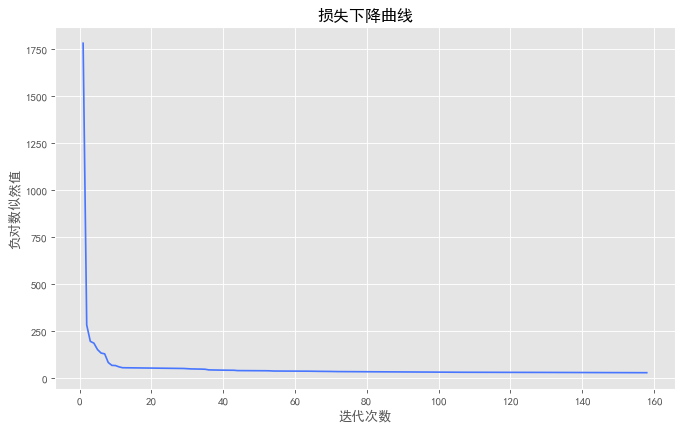

第 4 折：
训练 158 次，在训练集上：
准确率： 0.9868131868131869
查准率： 0.988950276243094 
查全率： 0.9781420765027322 
F1指标： 0.9835164835164836
在测试集上:
准确率： 0.9824561403508771
查准率： 0.9354838709677419 
查全率： 1.0 
F1指标： 0.9666666666666666
25.98919379086194


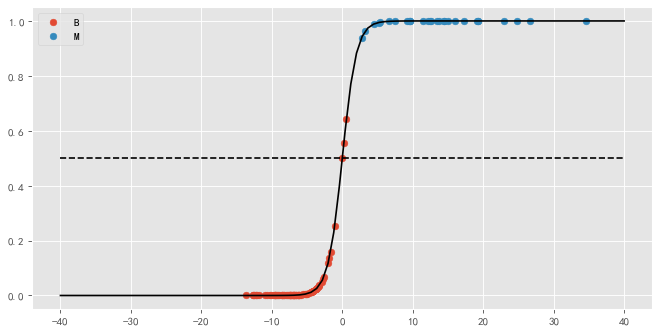

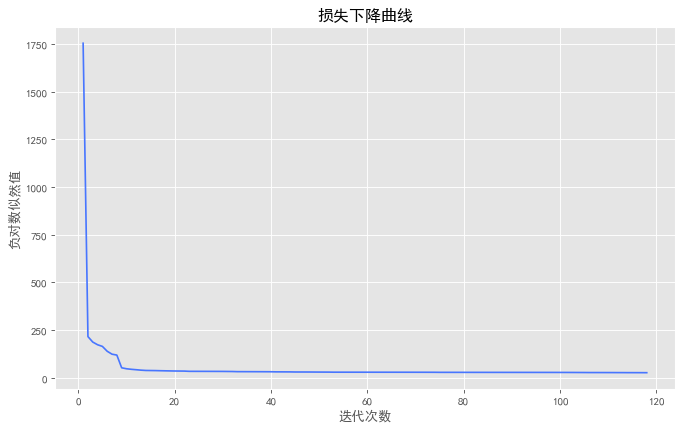

第 5 折：
训练 118 次，在训练集上：
准确率： 0.9802631578947368
查准率： 0.9783783783783784 
查全率： 0.9731182795698925 
F1指标： 0.9757412398921833
在测试集上:
准确率： 0.9911504424778761
查准率： 0.9629629629629629 
查全率： 1.0 
F1指标： 0.9811320754716981

平均准确率： 0.9754230709517155
查准率： 0.9723112376688814 
查全率： 0.9648499399759904 
F1指标： 0.9679350782562628


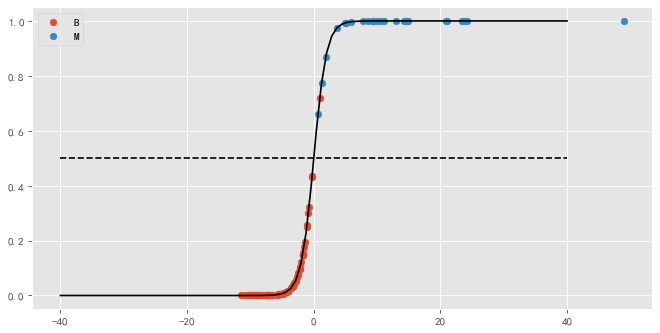

In [305]:
# k折
names=['ID','Label']
for i in range(30):
    names.append('f'+str(i+1))
df =  pd.read_csv("wdbc.data",names=names)

avg_acc=0
avg_P=0
avg_R=0
avg_F1=0

for i in range(5):
    df2=df[i*114:i*114+114]
    df1=pd.concat([df[0:i*114],df[i*114+114:569]])

    LR = LogisticRegression(Lambda=0.01,lr=0.05)
    df1=LR.pretreatment(df1)
    epochs = LR.fit(df1.iloc[:,2:33],df1.iloc[:,33])
    y_pre=LR.predict(df1.iloc[:,2:33])
    acc=get_acc(np.array(df1['Label']),y_pre)
    print('第',i+1,'折：')
    print('训练',epochs,'次，在训练集上：\n准确率：',acc)

    P,R,F1=get_F1(np.array(df1['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)

    df2=LR.pretreatment(df2,'test')
    y_pre=LR.predict(df2.iloc[:,2:33])
    acc=get_acc(np.array(df2['Label']),y_pre)
    print('在测试集上:\n准确率：',acc)
    avg_acc += acc
    P,R,F1=get_F1(np.array(df2['Label']),y_pre,'M')
    print('查准率：',P,'\n查全率：',R,'\nF1指标：',F1)
    avg_P += P
    avg_R += R
    avg_F1 += F1
    plotresult(df2)
    
print('\n平均准确率：',avg_acc/5)
print('查准率：',avg_P/5,'\n查全率：',avg_R/5,'\nF1指标：',avg_F1/5)